# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

В нашем распоряжении набор фотографий людей с указанием возраста. Обучим на них модель нейронной сети, значение метрики MAE при этом не должно быть больше 8.

**Цель исследования**: построить модель, которая по фотографии определит приблизительный возраст человека.

**Ход исследования**

Данные для исследования получим из файла `labels.csv`, изображения возьмем из папки `/final_files`. Перед обучением модели необходимо будет проанализировать и подготовить данные.

Таким образом, исследование пройдет в два этапа:
1. Исследовательский анализ данных.
2. Обучение модели.

## Исследовательский анализ данных

Для начала импортируем необходимые в работе библиотеки.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

Прочитаем файл `labels.csv` из каталога `faces` и сохраним его в одноименной переменной.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

Составим первое впечатление о данных:
1. Получим общую информацию методом `info()`.
2. Выведем на экран пять строк таблицы методом `sample()`. 
3. Оценим разброс значений методом `describe()`.

In [3]:
labels.info()
display(labels.sample(5))
display(labels.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,file_name,real_age
6314,006318.jpg,20
80,000080.jpg,27
50,000050.jpg,42
6879,006890.jpg,1
164,000164.jpg,50


,file_name,real_age
count,7591,7591.000000
unique,7591,NaN
top,004643.jpg,NaN
freq,1,NaN
mean,NaN,31.201159
std,NaN,17.145060
min,NaN,1.000000
25%,NaN,20.000000
50%,NaN,29.000000
75%,NaN,41.000000


Таблица состоит из двух признаков:
* file_name - наименование изображении;
* real_age - возраст человека на изображении.

Построим диаграмму распределения возраста в выборке методом `kdeplot()` библиотеки `seaborn`.

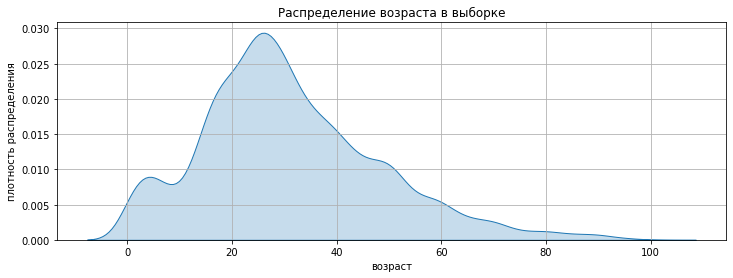

In [4]:
fig, ax = plt.subplots()
ax = sns.kdeplot(labels['real_age'], shade=True)
ax.set_title('Распределение возраста в выборке')
ax.set_xlabel('возраст')
ax.set_ylabel('плотность распределения')
ax.grid()
fig.set_figwidth(12)
plt.show()

По диагамме распределения видно, что большинство изображений выборки принадлежит к возрастной группе 20-30 лет. Изображения с гражданами пожилового возраста составляют только малую часть выборки.

Извлечем изображения из папки методом `flow_from_dataframe()` загрузчика `ImageDataGenerator`. Для лучшего качества обучения модели приведем значения пикселей к диапазону от 0 до 1, передав в параметре `rescale` значение 1./255. 

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


Отобразим на экране 10 случайных изображений.

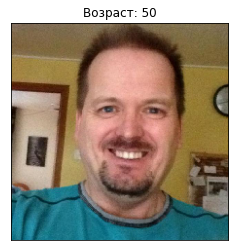

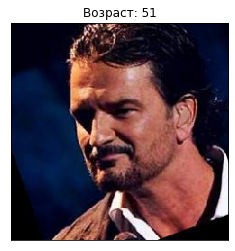

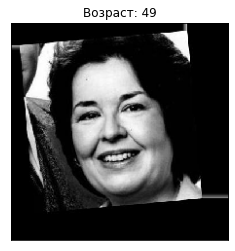

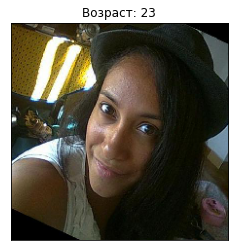

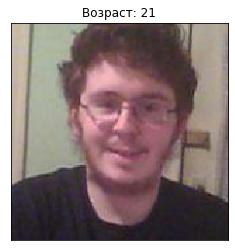

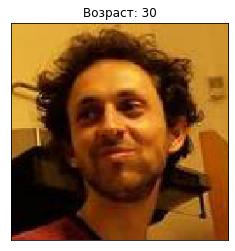

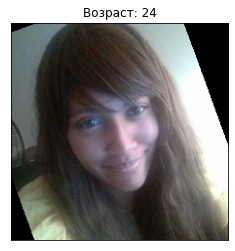

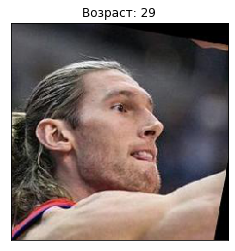

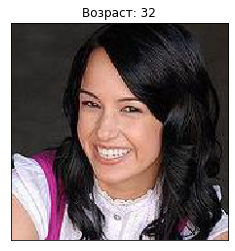

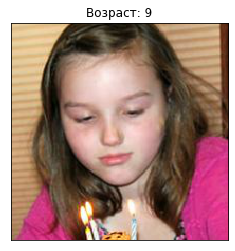

In [6]:
for _ in range(10):
    img, label = train_gen_flow.next()
    plt.imshow(img[0])
    plt.title("Возраст: " + str(label[0]))
    plt.xticks([])
    plt.yticks([])
    plt.show()

### Выводы

В нашем распоряжении набор из 7591 фотографии, большая часть людей на фотографии принадлежит возрастной группе от 20 до 30 лет. Обучим на имеющихся данных модель, минимизируя функцию потерь Mean Squared Error.

## Обучение модели

Для решения задачи регрессии будем использовать модель нейронной сети `ResNet`с последовательными слоями `GlobalAveragePooling2D` и `Dense` с активацией `Relu`. В качестве алгоритма оптимизации используем `Adam` с шагом 0.0001. На тренировочной части применим горизонтальный флип изображений.

```python
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.metrics import MeanAbsoluteError

labels = pd.read_csv('/datasets/faces/labels.csv')
    
train_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255,
    horizontal_flip=True)

validation_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255)

optimizer = Adam(lr=0.0001)

def load_train(path):
    train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory=path+'final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='training',
    seed=12345)
    
    return train_datagen_flow

def load_test(path):
    test_datagen_flow = validation_datagen.flow_from_dataframe(
    dataframe=labels,
    directory=path+'final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='validation',
    seed=12345)

    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=(150, 150, 3),
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False) 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mse', 
                  metrics=[MeanAbsoluteError()]) 

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model 
```

```python
2022-10-05 15:57:04.303941: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2022-10-05 15:57:04.302018: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2022-10-05 15:57:05.214109: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-10-05 15:57:05.224274: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-10-05 15:57:05.224349: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-10-05 15:57:05.224394: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-10-05 15:57:05.226453: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-10-05 15:57:05.226894: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-10-05 15:57:05.229421: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-10-05 15:57:05.231062: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-10-05 15:57:05.231134: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-10-05 15:57:05.235500: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2022-10-05 15:57:05.554611: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-10-05 15:57:05.562575: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099995000 Hz
2022-10-05 15:57:05.563285: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4fe1a70 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-10-05 15:57:05.563316: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-10-05 15:57:05.807334: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4ebefd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-10-05 15:57:05.807374: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2022-10-05 15:57:05.809863: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-10-05 15:57:05.809937: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-10-05 15:57:05.809952: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-10-05 15:57:05.809992: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-10-05 15:57:05.810009: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-10-05 15:57:05.810023: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-10-05 15:57:05.810038: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-10-05 15:57:05.810048: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-10-05 15:57:05.814795: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-10-05 15:57:05.814891: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-10-05 15:57:06.257316: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-10-05 15:57:06.257364: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2022-10-05 15:57:06.257372: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2022-10-05 15:57:06.262345: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-10-05 15:57:06.262413: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/5
2022-10-05 15:57:21.167744: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-10-05 15:57:21.597856: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 61s - loss: 214.1222 - mean_absolute_error: 10.5522 - val_loss: 639.1562 - val_mean_absolute_error: 20.3014
Epoch 2/5
178/178 - 40s - loss: 75.6396 - mean_absolute_error: 6.5346 - val_loss: 672.9510 - val_mean_absolute_error: 20.9035
Epoch 3/5
178/178 - 40s - loss: 46.4698 - mean_absolute_error: 5.1990 - val_loss: 281.4489 - val_mean_absolute_error: 12.3138
Epoch 4/5
178/178 - 42s - loss: 34.6359 - mean_absolute_error: 4.4767 - val_loss: 109.1802 - val_mean_absolute_error: 7.8653
Epoch 5/5
178/178 - 44s - loss: 27.3668 - mean_absolute_error: 4.0049 - val_loss: 76.2626 - val_mean_absolute_error: 6.5177
WARNING:tensorflow:sample_weight modes were coerced from
  ...
  ['...']
    to  
60/60 - 10s - loss: 76.2626 - mean_absolute_error: 6.5177
Test MAE: 6.5177
```

### Выводы

В качестве модели обучения была использована модель нейронной сети ResNet со слоями `GlobalAveragePooling2D` и `Dense`. Минимизируя функцию потерь MSE, модель показала значение метрики MAE на валидационной выборке, равное 6.52.

## Общий вывод

На основе фотографий людей и данных об их возрасте было проведено обучение модели нейронной сети `ResNet`. На валидационной выборке модель смогла достичь значение средней абсолютной ошибки (MAE) = 6.52, что удовлетворяет условиям исследования.

Согласно требованиям модель должна выполнять две задачи: предлагать товары, которые могут заинтересовать покупателей конкретной возрастной группы и контролировать добросовестность кассиров при продаже алкоголя. Т.к. в обучающей выборке было мало фотографий граждан пожилого возраста, то модель может недостаточно хорошо определять граждан этой возрастной группы для рекомендации им подходящих товаров. В то же время преобладающее количество фотографий граждан возраста 20-30 лет при обучении модели может негативно сказаться для решении задачи определения, является ли гражданин совершеннолетним. На мой взгляд, модель стоит дообучить, дополнив выборку фотографиями пожилых людей (60+) и граждан подросткового возраста (16-17 лет).